# Livrable 2 : Classification de photos, de peintures et autres images

Pour ce livrable 2, il nous est demandé de classifier des images données en trois catégories : Photo, Peinture, ou Autre. 
Pour ce faire nous avons suivi plusieurs étapes, en nous basant sur le tutoriel Tensorflow de Google permettant la classification d'image. 
Voici les différentes étapes : 

1. Préparer les données pour le Machine Learning, avec un tri des images potentiellement corrompues
2. Créer notre model
3. Entraîner notre modèle et analyser ses résulats 
4. Tester le modèle
5. Améliorer le modèle en fonction des résultats et répéter

## Import de TensorFlow et des autres librairies 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential



Ces deux lignes sont utilisées si l'on fait tourner le code en local et utiliser le GPU pour le faire tourner

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') #tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Préparation des données

Ligne utilisée pour vériifer que la carte graphique est correctement détectée 

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


Ici on indique juste que nos images sont situées dans le dossier data, situé dans le même répertoire que le Notebook

In [4]:
import pathlib

data_dir = pathlib.Path('data')

On vérifie qu'on a un jeu de données d'environ 40 000 images, moins les images ne possédant pas les bonnes métadata

In [5]:
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

39726


On peut ainsi afficher quelques images de différentes classes :

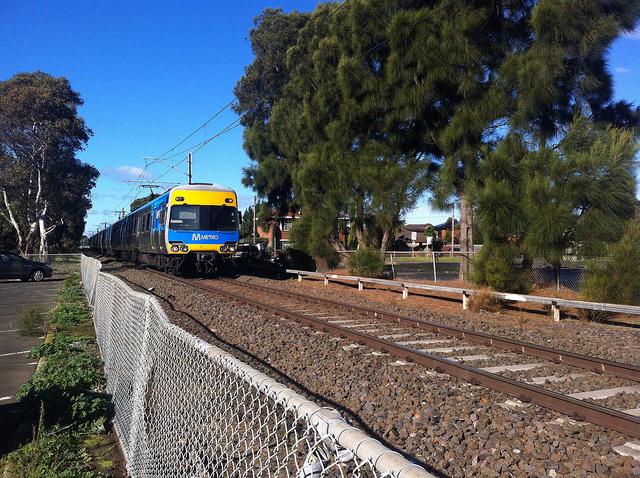

In [ ]:
photos = list(data_dir.glob('Photo/*'))
PIL.Image.open(str(photos[0]))

# Chargement des images à l'aide de keras

On utilise la méthode ``` image_dataset_from_diectory ``` afin de directement créer un dataset d'entraînement et de validation, directement depuis le dossier data contenant toutes nos images



## Create a dataset

In [6]:
batch_size = 32
img_height = 180
img_width = 180

On crée donc un dataset d'entraînement et de validation, afin de mesurer l'efficacité de notre modèle. On fournit 80% des données au jeu d'entraînement et 20 % à celui de validation.

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 39726 files belonging to 3 classes.
Using 31781 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 39726 files belonging to 3 classes.
Using 7945 files for validation.


On peut ensuite retrouver nos 3 classes, Peinture, Photo, et Autre dans les caractéristiques de notre dataset.

In [9]:
class_names = train_ds.class_names
print(class_names)

['Other', 'Painting', 'Photo']


## Configurer le dataset pour être plus performant

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.
On va précharger les données, afin d'éviter des problèmes d'Input Output. On va utiliser :

`Dataset.cache()` va garder les images en mémoire même après la première epoch.

`Dataset.prefetch()` permet de découpler le moment où les données sont produites du moment où les données sont consommées. On peut choisir le nombre d'éléments à précharger ou on peut utiliser `AUTOTUNE` afin de laisser la machine décider.

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Créer notre modèle

La première couche est une couche de standardisation. Les images étant RGB, les valeurs vont de 0 à 255, ce qui n'est pas optimisé pour un réseau neuronal. On va donc normaliser les données et les faire passer dans l'intervalle `[0, 1]` .


Je te laisse le décrire stp 

In [11]:
num_classes = 3

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## On compile notre modèle


In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

On peut vérifier si le modèle est bien construit en vérifiant les couches présentes dans le modèle.

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

## Entraîner le modèle

On va donc entraîner notre modèle. Comme on va avoir beaucoup d'epoch, on va également mettre en place un système d'arrêt prématuré. En effet si au bout d'un certain nombre d'epoch sans amélioration sur certains paramètres, on peut décider d'arrêter l'entraînement et ainsi garder seulement le meilleur modèle, avec les meilleurs poids, parmis ceux testés. 

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
modelsPath = "Basic_Model.hdf5"

modelcheckpoint = ModelCheckpoint(filepath=modelsPath,
                                  monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

# Callback permettant de retourner au meilleur modèle, et d'arrêter l'entrainement plus tôt, si aucune amélioration pendant un nombre d'époques défini
earlystop = EarlyStopping(monitor = 'val_accuracy',
                          min_delta = 0,
                          patience = 15,
                          verbose = 1,
                          restore_best_weights = True)


In [ ]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[modelcheckpoint, earlystop]
)

Epoch 1/20


## Résultats de l'entraînement

On va afficher un graphique permettant de visualiser l'évolution de notre précision et de notre fonction de perte

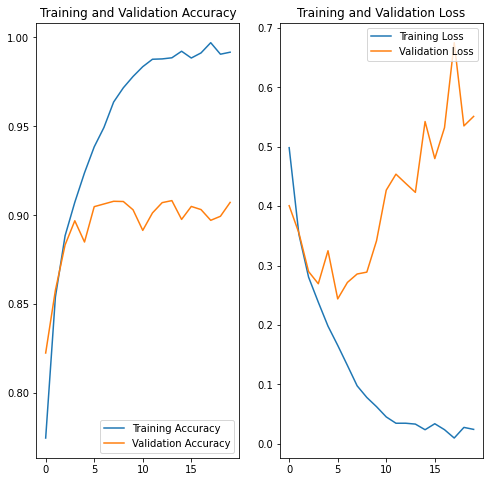

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

A compléter après test sur ordi

## Sur entraînement

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *Dropout* to your model.

## Augmentation du nombre de données

Afin d'éviter le surentraînement, on va tenter de fournir à notre modèle plus de données. Pour cela on va simplement appliquer différentes opérations sur les images comme une rotation, ou un zoom. 

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

## Dropout

On peut aussi également utilsier le dropout. Le dropout consiste à désactiver des neurones de façon aléatoire certains neurones, selon un certain pourcentage, comme 10, 20, 30.Cela veut dire que 10, 20 ou 30% des valeurs de sortie vont être ignorées par la couche suivante. 

On a donc modifié notre modèle afin d'ajouter le dropout et la data augmentation. 


In [ ]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## On recompile le modèle et on l'entraîne

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)       

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
modelsPath_dropout = "Modelsimplehdf5"

modelcheckpoint_dropout = ModelCheckpoint(filepath=modelsPath_dropout,
                                  monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

# Callback permettant de retourner au meilleur modèle, et d'arrêter l'entrainement plus tôt, si aucune amélioration pendant un nombre d'époques défini
earlystop_dropout = EarlyStopping(monitor = 'val_accuracy',
                          min_delta = 0,
                          patience = 10,
                          verbose = 1,
                          restore_best_weights = True)


In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[modelcheckpoint_dropout, earlystop_dropout]
)

Epoch 1/20
994/994 [==============================] - 203s 68ms/step - loss: 0.6289 - accuracy: 0.7195 - val_loss: 0.4186 - val_accuracy: 0.8274

Epoch 00001: val_accuracy improved from -inf to 0.82744, saving model to Modelsimplehdf5
INFO:tensorflow:Assets written to: Modelsimplehdf5\assets
Epoch 2/20
994/994 [==============================] - 41s 41ms/step - loss: 0.3802 - accuracy: 0.8410 - val_loss: 0.3826 - val_accuracy: 0.8507

Epoch 00002: val_accuracy improved from 0.82744 to 0.85072, saving model to Modelsimplehdf5
INFO:tensorflow:Assets written to: Modelsimplehdf5\assets
Epoch 3/20
994/994 [==============================] - 35s 35ms/step - loss: 0.3373 - accuracy: 0.8666 - val_loss: 0.4021 - val_accuracy: 0.8388

Epoch 00003: val_accuracy did not improve from 0.85072
Epoch 4/20
994/994 [==============================] - 42s 42ms/step - loss: 0.3054 - accuracy: 0.8781 - val_loss: 0.3340 - val_accuracy: 0.8697

Epoch 00004: val_accuracy improved from 0.85072 to 0.86973, saving 

In [ ]:
model.save_weights('./checkpoints/my_checkpoint')

## Résultats de l'entraînement

Après avoir appliqué l'augmentation des données, ainsi que du dropout on peut observer que les courbes sont plus proches et mieux allignées. 

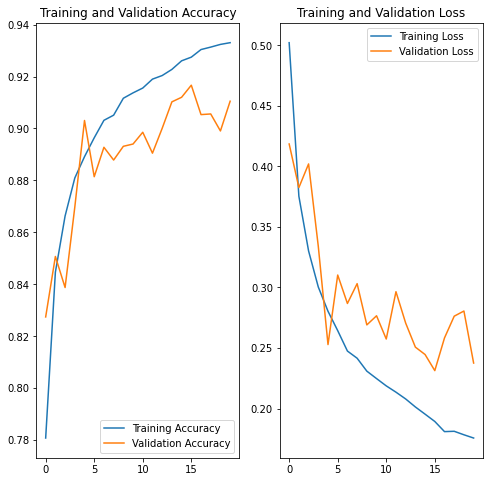

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Tester notre modèle

Durant notre travail nous avons testé plusieurs modèles, qui nous ont donné des résultats plus ou moins satisfaisant. Nous les avons bien entendu enregistrés afin de pouvoir comparer leur efficacité avec notre modèle actuel, qui est celui proposé par Google, dans son tutoriel de classification d'images. 

Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and Dropout layers are inactive at inference time.

In [ ]:

new_model = tf.keras.models.load_model('Model_pixel_without_da.hdf5')

#folder_path = "test"
#    for fname in os.listdir(folder_path):
#        fpath = os.path.join(folder_path, fname)
#        try:
           

import pandas as pd
final_2 = pd.DataFrame(columns=['correct', 'score', 'filename'])

folder_path = "test"
i = 0
for fname in os.listdir(folder_path):
    if i == 1000:
        break
    fpath = os.path.join(folder_path, fname)
    img = keras.preprocessing.image.load_img('test/'+fname, target_size=(img_height, img_width))           
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = new_model.predict(img_array)
    score = predictions[0]
    if(class_names[np.argmax(score)] == "Photo"):
        final_2 = final_2.append({'correct':True, 'score':100 * np.max(score), 'filename':fname}, ignore_index=True)
    else:
        final_2 = final_2.append({'correct':False, 'score':100 * np.max(score), 'filename':fname}, ignore_index=True)
    i = i + 1

In [ ]:
average = final_2['score'].sum() / 1000
print(average)
correct = final_2['correct'].sum() / 1000
print(correct)

90.12470094561577
0.844


In [ ]:
import pandas as pd
final = pd.DataFrame(columns=['correct', 'score', 'filename'])

folder_path = "test"
i = 0
for fname in os.listdir(folder_path):
    if i == 1000:
        break
    fpath = os.path.join(folder_path, fname)
    img = keras.preprocessing.image.load_img('test/'+fname, target_size=(img_height, img_width))           
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    if(class_names[np.argmax(score)] == "Photo"):
        final = final.append({'correct':True, 'score':100 * np.max(score), 'filename':fname}, ignore_index=True)
    else:
        final = final.append({'correct':False, 'score':100 * np.max(score), 'filename':fname}, ignore_index=True)
    i = i + 1

In [ ]:
average = final['score'].sum() / 1000
print(average)

91.29164867401123


In [ ]:
correct = final['correct'].sum() / 1000
print(correct)

0.904
